# Trace Analysis Examples

## Idle States Residency Analysis

This notebook shows the features provided by the idle state analysis module. It will be necessary to collect the following events:

 - `cpu_idle`, to filter out intervals of time in which the CPU is idle
 - `sched_switch`, to recognise tasks on kernelshark
 
Details on idle states profiling ar given in **Per-CPU/Per-Cluster Idle State Residency Profiling** below.

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2017-01-20 11:54:37,100 INFO    : root         : Using LISA logging configuration:
2017-01-20 11:54:37,100 INFO    : root         :   /home/vagrant/lisa/logging.conf


In [2]:
%matplotlib inline

import os

# Support to access the remote target
from env import TestEnv

# Support to access cpuidle information from the target
from devlib import *

# Support to configure and run RTApp based workloads
from wlgen import RTA, Ramp

# Support for trace events analysis
from trace import Trace

# DataFrame support
import pandas as pd
from pandas import DataFrame

# Trappy (plots) support
from trappy import ILinePlot
from trappy.stats.grammar import Parser

## Target Configuration
The target configuration is used to describe and configure your test environment.
You can find more details in **examples/utils/testenv_example.ipynb**.

Our target is a Juno R0 development board running Linux.

In [3]:
# Setup a target configuration
my_conf = {
    
    # Target platform and board
    "platform"    : 'linux',
    "board"       : 'juno',
    
    # Target board IP/MAC address
    "host"        : '192.168.0.1',
    
    # Login credentials
    "username"    : 'root',
    "password"    : 'juno',
    
    "results_dir" : "IdleAnalysis",
    
    # RTApp calibration values (comment to let LISA do a calibration run)
    #"rtapp-calib" :  {
    #    "0": 318, "1": 125, "2": 124, "3": 318, "4": 318, "5": 319
    #},
    
    # Tools required by the experiments
    "tools"   : ['rt-app', 'trace-cmd'],
    "modules" : ['bl', 'cpufreq', 'cpuidle'],
    "exclude_modules" : ['hwmon'],
    
    # FTrace events to collect for all the tests configuration which have
    # the "ftrace" flag enabled
    "ftrace"  : {
         "events" : [
            "cpu_idle",
            "sched_switch"
         ],
         "buffsize" : 10 * 1024,
    },
}

In [4]:
# Initialize a test environment
te = TestEnv(my_conf, wipe=False, force_new=True)
target = te.target

2017-01-20 11:54:39,398 INFO    : TestEnv      : Using base path: /home/vagrant/lisa
2017-01-20 11:54:39,399 INFO    : TestEnv      : Loading custom (inline) target configuration
2017-01-20 11:54:39,399 INFO    : TestEnv      : Devlib modules to load: ['bl', 'cpuidle', 'cpufreq']
2017-01-20 11:54:39,400 INFO    : TestEnv      : Connecting linux target:
2017-01-20 11:54:39,400 INFO    : TestEnv      :   username : root
2017-01-20 11:54:39,401 INFO    : TestEnv      :       host : 192.168.0.1
2017-01-20 11:54:39,401 INFO    : TestEnv      :   password : juno
2017-01-20 11:54:39,401 INFO    : TestEnv      : Connection settings:
2017-01-20 11:54:39,402 INFO    : TestEnv      :    {'username': 'root', 'host': '192.168.0.1', 'password': 'juno'}
2017-01-20 11:54:46,668 INFO    : TestEnv      : Initializing target workdir:
2017-01-20 11:54:46,669 INFO    : TestEnv      :    /root/devlib-target
2017-01-20 11:55:02,855 INFO    : TestEnv      : Topology:
2017-01-20 11:55:02,856 INFO    : TestEnv 

In [5]:
# We're going to run quite a heavy workload to try and create short idle periods.
# Let's set the CPU frequency to max to make sure those idle periods exist
# (otherwise at a lower frequency the workload might overload the CPU
#  so it never went idle at all)
te.target.cpufreq.set_all_governors('performance')

''

## Workload configuration and execution

Detailed information on RTApp can be found in **examples/wlgen/rtapp_example.ipynb**.

This experiment:
- Runs a periodic RT-App workload, pinned to CPU 1, that ramps down from 80% to 10% over 7.5 seconds
- Uses `perturb_cpus` to ensure 'cpu_idle' events are present in the trace for all CPUs
- Triggers and collects ftrace output

In [6]:
cpu = 1
def experiment(te):

    # Create RTApp RAMP task
    rtapp = RTA(te.target, 'ramp', calibration=te.calibration())
    rtapp.conf(kind='profile',
               params={
                    'ramp' : Ramp(
                        start_pct =  80,
                        end_pct   =  10,
                        delta_pct =  5,
                        time_s    =  0.5,
                        period_ms =  5,
                        cpus =       [cpu]).get()
              })

    # FTrace the execution of this workload
    te.ftrace.start()
    # Momentarily wake all CPUs to ensure cpu_idle trace events are present from the beginning
    te.target.cpuidle.perturb_cpus()
    rtapp.run(out_dir=te.res_dir)
    te.ftrace.stop()

    # Collect and keep track of the trace
    trace_file = os.path.join(te.res_dir, 'trace.dat')
    te.ftrace.get_trace(trace_file)

    # Dump platform descriptor
    te.platform_dump(te.res_dir)

In [7]:
experiment(te)

2017-01-20 11:55:44,654 INFO    : Workload     : Setup new workload ramp
2017-01-20 11:55:44,655 INFO    : Workload     : Workload duration defined by longest task
2017-01-20 11:55:44,655 INFO    : Workload     : Default policy: SCHED_OTHER
2017-01-20 11:55:44,656 INFO    : Workload     : ------------------------
2017-01-20 11:55:44,656 INFO    : Workload     : task [ramp], sched: using default policy
2017-01-20 11:55:44,656 INFO    : Workload     :  | calibration CPU: 1
2017-01-20 11:55:44,657 INFO    : Workload     :  | loops count: 1
2017-01-20 11:55:44,657 INFO    : Workload     :  | CPUs affinity: [1]
2017-01-20 11:55:44,658 INFO    : Workload     : + phase_000001: duration 0.500000 [s] (100 loops)
2017-01-20 11:55:44,658 INFO    : Workload     : |  period     5000 [us], duty_cycle  80 %
2017-01-20 11:55:44,658 INFO    : Workload     : |  run_time   4000 [us], sleep_time   1000 [us]
2017-01-20 11:55:44,659 INFO    : Workload     : + phase_000002: duration 0.500000 [s] (100 loops)


2017-01-20 11:55:52,296 INFO    : Workload     : Workload execution START:
2017-01-20 11:55:52,297 INFO    : Workload     :    /root/devlib-target/bin/rt-app /root/devlib-target/ramp_00.json 2>&1


## Parse trace and analyse data

In [8]:
# Base folder where tests folder are located
res_dir = te.res_dir
logging.info('Content of the output folder %s', res_dir)
!tree {res_dir}

2017-01-20 11:56:11,164 INFO    : root         : Content of the output folder /home/vagrant/lisa/results/IdleAnalysis


/home/vagrant/lisa/results/IdleAnalysis
├── cluster_idle_state_residency.png
├── cpu_idle_state_residency.png
├── output.log
├── platform.json
├── ramp_00.json
├── rt-app-ramp-0.log
├── trace.dat
├── trace.raw.txt
└── trace.txt

0 directories, 9 files


In [9]:
trace = Trace(res_dir, my_conf['ftrace']['events'], te.platform)

## Per-CPU Idle State Residency Profiling

It is possible to get the residency in each idle state of a CPU or a cluster with the following commands:

In [10]:
# Idle state residency for CPU 3
CPU=3
state_res = trace.data_frame.cpu_idle_state_residency(CPU)
state_res

,time
idle_state,
0,0.042726
1,6.178961
2,10.367166


For the translation between the idle value and its description:

In [11]:
DataFrame(data={'value':  state_res.index.values,
                'name': [te.target.cpuidle.get_state(i, cpu=CPU) for i in state_res.index.values]})

,name,value
0,"CpuidleState(WFI, ARM WFI)",0
1,"CpuidleState(cpu-sleep-0, cpu-sleep-0)",1
2,"CpuidleState(cluster-sleep-0, cluster-sleep-0)",2


The **IdleAnalysis** module provide methods for plotting residency data:

In [12]:
ia = trace.analysis.idle

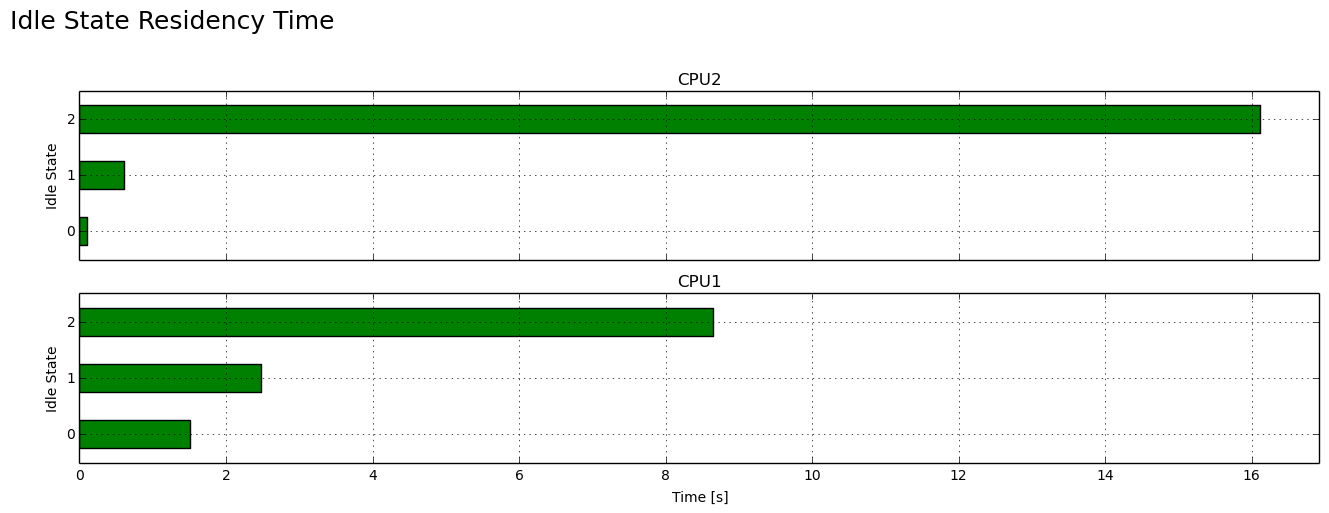

In [13]:
# Actual time spent in each idle state
ia.plotCPUIdleStateResidency([1,2])

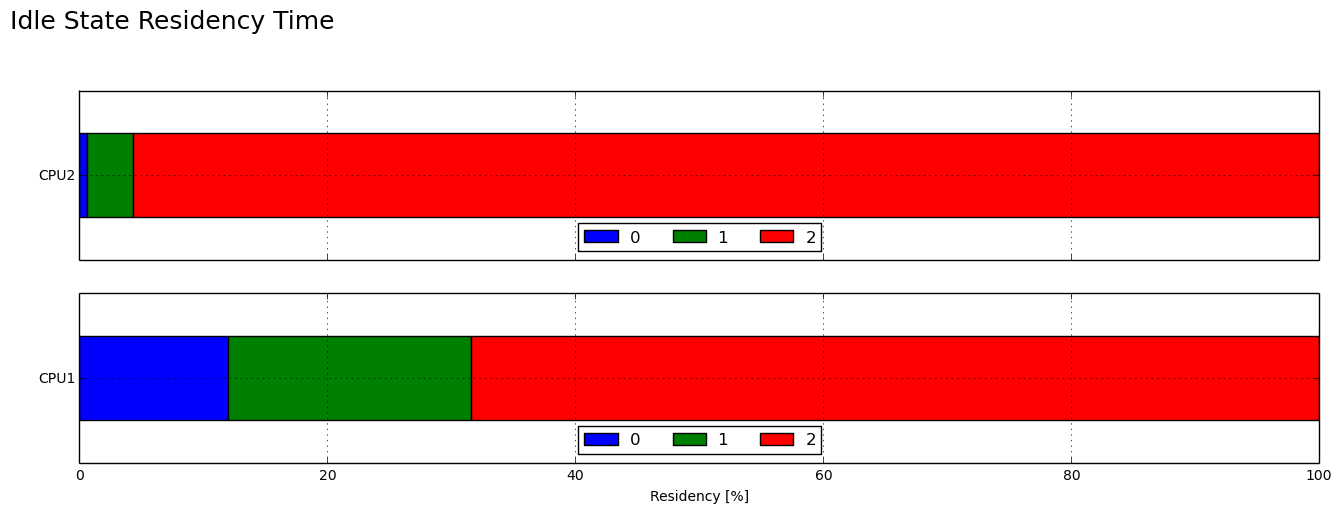

In [14]:
# Percentage of time spent in each idle state
ia.plotCPUIdleStateResidency([1,2], pct=True)

## CPU idle state over time

Take a look at the target's idle states:

In [15]:
te.target.cpuidle.get_states()

[CpuidleState(WFI, ARM WFI),
 CpuidleState(cpu-sleep-0, cpu-sleep-0),
 CpuidleState(cluster-sleep-0, cluster-sleep-0)]

Now use trappy to plot the idle state of a single CPU over time. Higher is deeper: the plot is at -1 when the CPU is active, 0 for WFI, 1 for CPU sleep, etc.

We should see that as the workload ramps down and the idle periods become longer, the idle states used become deeper.

In [16]:
p = Parser(trace.ftrace, filters = {'cpu_id': cpu})
idle_df = p.solve('cpu_idle:state')
ILinePlot(idle_df, column=cpu, drawstyle='steps-post').view()

""
""


## Examine idle period lengths
Let's get a DataFrame showing the length of each idle period on the CPU and the index of the cpuidle state that was entered.

In [17]:
def get_idle_periods(df):
    series = df[cpu]
    series = series[series.shift() != series].dropna()
    if series.iloc[0] == -1:
        series = series.iloc[1:]

    idles = series.iloc[0::2] 
    wakeups = series.iloc[1::2]
    if len(idles) > len(wakeups):
        idles = idles.iloc[:-1]
    else:
        wakeups = wakeups.iloc[:-1]

    lengths = pd.Series((wakeups.index - idles.index), index=idles.index)
    return pd.DataFrame({"length": lengths, "state": idles})

Make a scatter plot of the length of idle periods against the state that was entered. We should see that for long idle periods, deeper states were entered (i.e. we should see a positive corellation between the X and Y axes).

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


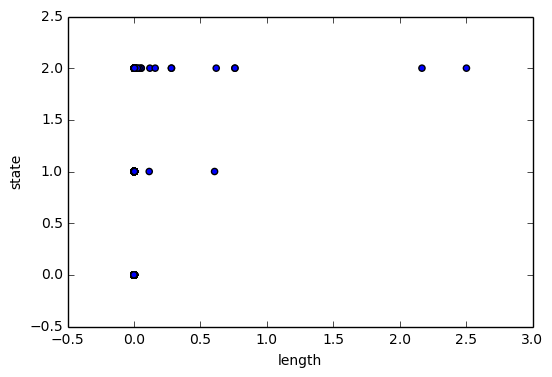

In [18]:
lengths = get_idle_periods(idle_df)
lengths.plot(kind='scatter', x='length', y='state')

Draw a histogram of the length of idle periods shorter than 100ms in which the CPU entered cpuidle state 2.

array([[<matplotlib.axes.AxesSubplot object at 0x7fd95656f710>]], dtype=object)

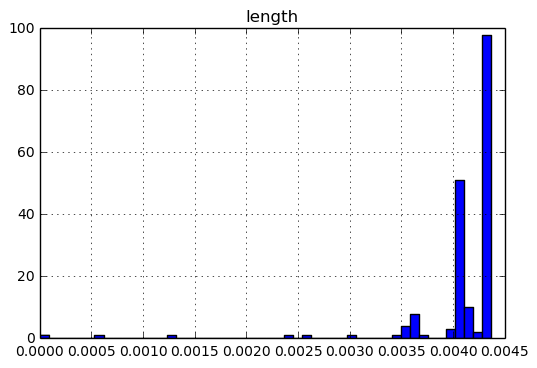

In [19]:
df = lengths[(lengths['state'] == 2) & (lengths['length'] < 0.010)]
df.hist(column='length', bins=50)

## Per-cluster Idle State Residency

In [20]:
# Idle state residency for CPUs in the big cluster
trace.data_frame.cluster_idle_state_residency('big')

,time
idle_state,
0,1.527443
1,2.709098
2,8.609212


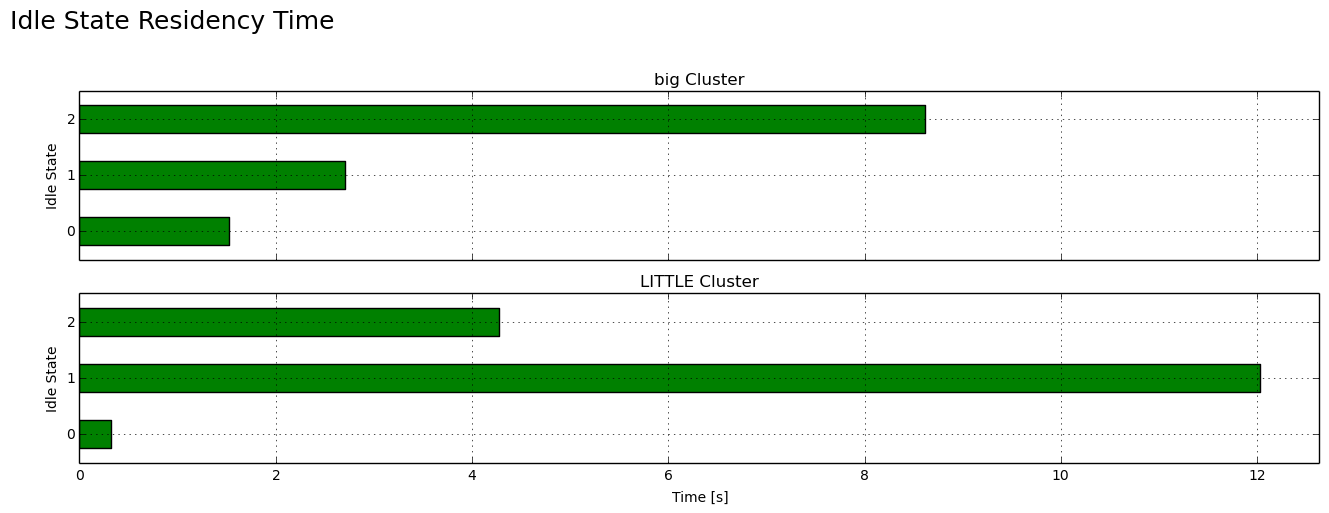

In [21]:
# Actual time spent in each idle state for CPUs in the big and LITTLE clusters
ia.plotClusterIdleStateResidency(['big', 'LITTLE'])

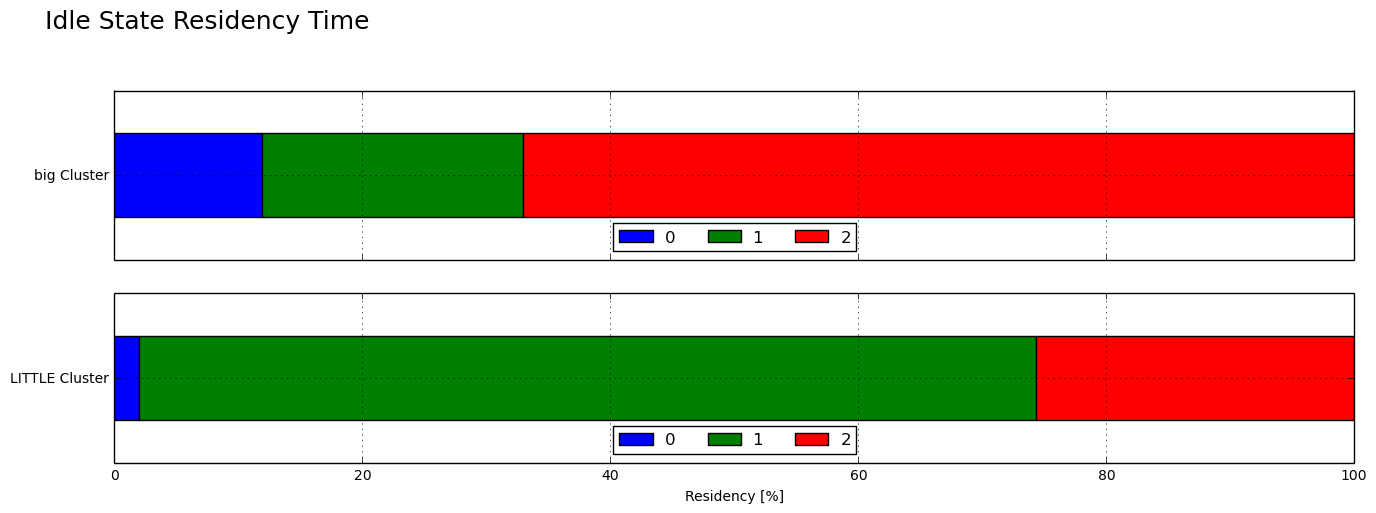

In [22]:
# Percentage of time spent in each idle state for CPUs in the big and LITTLE clusters
ia.plotClusterIdleStateResidency(['big', 'LITTLE'], pct=True)